#### **Import Libraries**

In [1]:
from IPython.display import display
from IPython.display import Markdown
import textwrap
import os 
from pathlib import Path
import pandas as pd
import tiktoken
from pathlib import Path
from trics.nlp.utils import to_markdown, create_csv_with_headers
import csv
import time 
import logging
import re 
import numpy as np
import anthropic

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-ExtraBoldItalic.ttf


In [3]:
version = 2
prompt = False 
sample_size = 3000
noise = False

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

In [6]:
conditions_not_covered = [
    "Good Health",
    "Mild Behavioral and Psychological Traits",
    "Temporary Conditions"]

conditions_covered = [
    "Mobility and Physical Disabilities",
    "Chronic and Severe Illnesses",
    "Developmental Disabilities",
    "Severe Cognitive and Learning Disabilities",
    "Psychiatric and Severe Mental Health Disorders"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7):
    return 0.25*(var5 >= 5) + 0.35*var7

In [15]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "Note: The tenant has access to a free lawyer."
string0 = "Note: The tenant does not have access to a free lawyer."

context = " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1, df['Description'] + string1, df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

def received(x):
    return  'The tenant received legal representation' if x == 1 else 'The tenant did not receive legal representation.'

df['Treatment_word'] = df.Treatment.apply(received)
# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

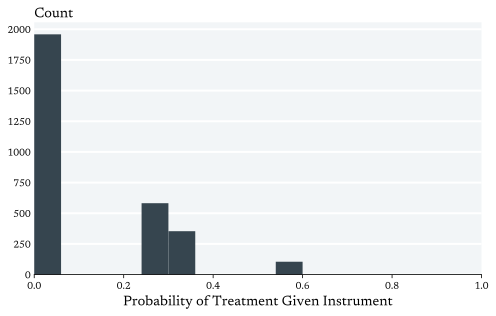

In [16]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Setup Client**

In [81]:
def anthropic_completion(prompt, model="claude-3-haiku-20240307"):
    message = client.messages.create(
        model=model,
        max_tokens=200,
        temperature=0.0,
        system="You are an expert in pattern recognition.",
        messages=[{"role": "user", "content": prompt}]
    )
    return message.content[0].text.strip()

In [102]:

def initiate_prompt(context, examples, test_example):
    prompt = f"""
    Task: Based only on the following Context and Examples (do not use outside world knowledge), predict the probability that the tenant described in the Test Example receives legal representation. Your response should be an exact number.

    Context:
    ```
    {context}
    ```

    Examples:
    ```
    {examples}
    ```

    Test Example:
    ```
    {test_example}
    ```

    Before you respond:
    - Check if your rationale is logical. Are there any inconsistencies?

    Your response should include:
    - The probability that the tenant in the Test Example receives legal representation as an exact number (e.g., 0.03 for 3%).

    Hint:
    - Have tenants who have a similar description as the test example received legal representation?

    Prediction:
    """
    return prompt 

In [103]:
df.shape

(3000, 16)

In [131]:
k = 2000
examples = df.loc[:k, 'FullDescription'] + ' ' + df.loc[:k, 'Treatment_word']
test_example = df.loc[k+3, 'FullDescription']
prompt = initiate_prompt(examples.values, context, test_example)

In [132]:
to_markdown(test_example)

> The tenant is a 38-year-old individual with developmental disabilities who lives in a small apartment complex and relies on a housing voucher to afford their rent. They have been residing in the same apartment for over 4 years, having lived there for 51 months. Despite their stable living situation, the tenant is currently behind on their rent, owing $1431. Amidst the financial challenges, the tenant has found solace in maintaining a small garden on their balcony and caring for a fish tank, which provides them with a sense of purpose and connection to their home.Note: The tenant has access to a free lawyer.

In [133]:
to_markdown(anthropic_completion(prompt, 'claude-3-opus-20240229'))

> Based on the context and examples provided, I predict the probability that the tenant in the Test Example receives legal representation is 0.75.
> 
> Rationale:
> The tenant in the Test Example has several characteristics that suggest they would be prioritized for legal representation by legal aid providers:
> 
> 1. The tenant has developmental disabilities, which is considered a disability that legal aid providers prioritize when reviewing applications for representation.
> 
> 2. The tenant relies on a housing voucher to afford their rent. Tenants with vouchers are also prioritized by legal aid providers.
> 
> 3. The tenant has been living in the same apartment for a long time (51 months), indicating a stable living situation.
> 
> However, the examples also mention that even if a tenant has characteristics that suggest they should be prioritized, it's still possible they may not receive representation. The tenant must apply for representation and follow up with the provider to arrange it.
> 
> Considering the strong factors in favor of priorit